In [34]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(15,5)
pd.set_option('display.max_columns', 100)

import nltk
from scipy import stats
import re
from  scipy.stats import ttest_ind
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score,train_test_split,RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator,TransformerMixin

### **Read the data and split into training and test datasets. We will be using the training part to further split into training and validation part. Once we find a good model we will test it's performance on unseen data (test dataset)**

In [2]:
data=pd.read_csv('Data/cleanedData.csv')
data.dropna(subset=['CleanWordList'],inplace=True)

# Meta features
cols=['COMMENT_ID','%OfUpperCaseLetters', 'NoOfURL', 'AvgLengthOfEachWord',
       '%OfNoOfStopWords', 'NoOfWords', '%OfNoOfUniqueWords',
       'AvgSentenceLength', 'TextStandard', 'CleanWordList']

X=data.loc[:,cols]
y=data['CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,stratify=y,random_state=147)

In [3]:
print('X_train, X_test, y_train, y_test: ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train, X_test, y_train, y_test:  (1334, 10) (572, 10) (1334,) (572,)


### **Compare CountVectorizer and TfidfVectorizer by passing the document-term-matrix from the two vectorizers through MultinomialNB()**

#### **Create a switcher function to call for different estimators to test**

Reference: https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers

In [4]:
class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=LogisticRegression(),):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        Default estimator: LogisticRegression()
        """ 
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

In [5]:
class Transfomer(BaseEstimator, TransformerMixin):
    
    def __init__(self,vectorizer=CountVectorizer()):
        self.vectorizer=vectorizer
        self.X=X

    def fit(self, X, y=None):
        """
        Learn how to transform data based on input data, X.
        """
        return self.vectorizer.fit(X)

    def transform(self, X):
        """
        Transform X into a new dataset, Xprime and return it.
        """
        return self.vectorizer.transform(X).toarray()

In [6]:
pipe_CompareVectorizer= Pipeline([('vectorizer',Transfomer()),
                                  ('clf', ClfSwitcher())
                                ])
paramGrid_CompareVectorizer=[ {
                            'vectorizer__vectorizer':[TfidfVectorizer()],
                            'vectorizer__vectorizer__min_df':[0.1,0.01,0.001,0.0001],
                            'vectorizer__vectorizer__ngram_range':[(1,2),(1,3)],
                            'clf__estimator':[MultinomialNB()]
                              },
                              {
                            'vectorizer__vectorizer':[CountVectorizer()],
                            'vectorizer__vectorizer__min_df':[0.1,0.01,0.001,0.0001],
                            'vectorizer__vectorizer__ngram_range':[(1,2),(1,3)],
                            'clf__estimator':[MultinomialNB()]
                              }
                            ]

In [7]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# Gridsearch with count vectorizer and TFIDF
gs_CompareVectorizer = GridSearchCV(pipe_CompareVectorizer, param_grid=paramGrid_CompareVectorizer,n_jobs=-1,
                                    cv=cv, verbose=0,return_train_score=True,scoring='roc_auc')

gs_CompareVectorizer.fit(X_train['CleanWordList'],y_train);


gs_CompareVectorizer.best_params_['vectorizer__vectorizer']

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.0001,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [8]:
compareVectorizer=pd.DataFrame(gs_CompareVectorizer.cv_results_['params'],
                  gs_CompareVectorizer.cv_results_['mean_train_score']).reset_index()
compareVectorizer['clf__estimator']=pd.DataFrame(gs_CompareVectorizer.cv_results_['params'])['clf__estimator'].apply(lambda x: str(x).split('(')[0])
compareVectorizer['vectorizer__vectorizer']=pd.DataFrame(gs_CompareVectorizer.cv_results_['params'])['vectorizer__vectorizer'].apply(lambda x: str(x).split('(')[0])

In [9]:
compareVectorizer.rename(columns={'index':'ROC_AUC_SCORE',
                    'clf__estimator':'Estimator',
                    'vectorizer__vectorizer':'Vectorizer',
                    'vectorizer__vectorizer__min_df':'min_df',
                    'vectorizer__vectorizer__ngram_range':'ngram_range'},inplace=True)
compareVectorizer.sort_values(by=['ROC_AUC_SCORE'],ascending=False,inplace=True)
compareVectorizer.reset_index(inplace=True,drop=True)
compareVectorizer

,ROC_AUC_SCORE,Estimator,Vectorizer,min_df,ngram_range
0,0.997874,MultinomialNB,TfidfVectorizer,0.0001,"(1, 3)"
1,0.997486,MultinomialNB,CountVectorizer,0.0001,"(1, 3)"
2,0.996941,MultinomialNB,TfidfVectorizer,0.0001,"(1, 2)"
3,0.995843,MultinomialNB,CountVectorizer,0.0001,"(1, 2)"
4,0.985767,MultinomialNB,TfidfVectorizer,0.0010,"(1, 3)"
5,0.985718,MultinomialNB,TfidfVectorizer,0.0010,"(1, 2)"
6,0.976036,MultinomialNB,CountVectorizer,0.0010,"(1, 2)"
7,0.972663,MultinomialNB,CountVectorizer,0.0010,"(1, 3)"
8,0.957977,MultinomialNB,TfidfVectorizer,0.0100,"(1, 2)"
9,0.957009,MultinomialNB,TfidfVectorizer,0.0100,"(1, 3)"


In [10]:
gs_CompareVectorizer.best_score_

0.9629218191240957

###  **Using vectorizer selected above, create pipeline, and perform grid search to find best estimator and best parameters.**

In [11]:
pipe = Pipeline([
                    ('vectorizer',gs_CompareVectorizer.best_estimator_['vectorizer']),
                    ('clf', ClfSwitcher())
                    ])

parameters =[
            {'clf__estimator':[MultinomialNB()]},
            {'clf__estimator':[LogisticRegression()]},
            {'clf__estimator':[RandomForestClassifier()]},
            {'clf__estimator':[XGBClassifier()]},
            {'clf__estimator':[SVC(probability=True)]}
            ]

# Gridsearch with count vectorizer and TFIDF
gs_CV = GridSearchCV(pipe, parameters,n_jobs=-1, cv=cv, verbose=0,return_train_score=True,scoring='roc_auc')

gs_CV.fit(X_train['CleanWordList'],y_train);

**Find the best estimator and best parameters for all of the data (vectorized text + engineered Features)**

In [42]:
compareEstimator=pd.DataFrame(gs_CV.cv_results_)

compareEstimator['estimator']=pd.DataFrame(gs_CV.cv_results_['params'])['clf__estimator'].apply(lambda x: str(x).split('(')[0])

compareEstimator=compareEstimator[['rank_test_score','estimator','mean_train_score','mean_test_score']] 

compareEstimator.sort_values(by='rank_test_score',inplace=True)
compareEstimator.style.highlight_max(axis=0,subset=['mean_test_score'])

,rank_test_score,estimator,mean_train_score,mean_test_score
1,1,LogisticRegression,0.999433,0.970549
0,2,MultinomialNB,0.995843,0.962922
2,3,RandomForestClassifier,0.99982,0.948763
4,4,SVC,0.946319,0.930726
3,5,XGBClassifier,0.516422,0.518428


**Gridsearch Logistic Regression Classifier**

In [14]:
pipe_LR = Pipeline([
                    ('vectorizer',gs_CompareVectorizer.best_estimator_['vectorizer']),
                    ('clf', LogisticRegression())
                    ])

param_LR ={'clf__C':(0.1,0.5,1,2,20,50,100,500)}

gs_LR = RandomizedSearchCV(pipe_LR,param_LR,n_jobs=-1, cv=cv, verbose=0,return_train_score=True,scoring='roc_auc')

gs_LR.fit(X_train['CleanWordList'],y_train);

print('Best param: ',gs_LR.best_params_,'\n','Best Score: ',gs_LR.best_score_)

Best param:  {'clf__C': 2} 
 Best Score:  0.9717562687922022


**Gridsearch Multinomial Naive Bayes**

In [15]:
pipe_MNB = Pipeline([
                    ('vectorizer',gs_CompareVectorizer.best_estimator_['vectorizer']),
                    ('clf', MultinomialNB())
                    ])

param_MNB ={'clf__alpha':(0,0.1,0.5,1,2,20,100),
            'clf__fit_prior':(True,False)}

gs_MNB = RandomizedSearchCV(pipe_MNB,param_MNB,n_jobs=-1, cv=cv, verbose=0,return_train_score=True,scoring='roc_auc')

gs_MNB.fit(X_train['CleanWordList'],y_train);

print('Best param: ',gs_MNB.best_params_,'\n','Best Score: ',gs_MNB.best_score_)

Best param:  {'clf__fit_prior': False, 'clf__alpha': 2} 
 Best Score:  0.9636086522732104


**Gridsearch Random Forest Classifier**

In [16]:
pipe_RFC = Pipeline([
                    ('vectorizer',gs_CompareVectorizer.best_estimator_['vectorizer']),
                    ('clf', RandomForestClassifier())
                    ])

param_RFC ={'clf__n_estimators':(10,50,100,500,1000),
            'clf__max_depth':(2,5,10,50,100,500,1000)}

gs_RFC = RandomizedSearchCV(pipe_RFC,param_RFC,n_jobs=-1, cv=cv, verbose=0,return_train_score=True,scoring='roc_auc')

gs_RFC.fit(X_train['CleanWordList'],y_train);

print('Best param: ',gs_RFC.best_params_,'\n','Best Score: ',gs_RFC.best_score_)

Best param:  {'clf__n_estimators': 100, 'clf__max_depth': 50} 
 Best Score:  0.9699341778585583


**Gridsearch SVC**

In [17]:
pipe_SVC = Pipeline([
                    ('vectorizer',gs_CompareVectorizer.best_estimator_['vectorizer']),
                    ('clf', SVC())
                    ])

param_SVC ={'clf__C':(0.1,0.5,1,2,20,50,100,500)}

gs_SVC = RandomizedSearchCV(pipe_SVC,param_SVC,n_jobs=-1, cv=cv, verbose=0,return_train_score=True,scoring='roc_auc')

gs_SVC.fit(X_train['CleanWordList'],y_train);

print('Best param: ',gs_SVC.best_params_,'\n','Best Score: ',gs_SVC.best_score_)

Best param:  {'clf__C': 500} 
 Best Score:  0.970415417921764


**Gridsearch XGBoost Classifier**

In [18]:
pipe_XGB = Pipeline([
                    ('vectorizer',gs_CompareVectorizer.best_estimator_['vectorizer']),
                    ('clf', XGBClassifier())
                    ])

param_XGB ={'clf__n_estimators':(10,50,100,500,1000),
            'clf__max_depth':(2,5,10,50,100,500,1000)}

gs_XGB = RandomizedSearchCV(pipe_XGB,param_XGB,n_jobs=-1, cv=cv, verbose=0,return_train_score=True,scoring='roc_auc')

gs_XGB.fit(X_train['CleanWordList'],y_train);

print('Best param: ',gs_XGB.best_params_,'\n','Best Score: ',gs_XGB.best_score_)

Best param:  {'clf__n_estimators': 100, 'clf__max_depth': 2} 
 Best Score:  0.527330378506368


**Display result of grid searches**

In [19]:
compareEstimator_df=pd.DataFrame(data={'Logistic Regression':[gs_LR.best_params_,gs_LR.best_score_],
 'Multinomial Naive Bayes':[gs_MNB.best_params_,gs_MNB.best_score_],
 'Random Forest':[gs_RFC.best_params_,gs_RFC.best_score_],
 'SVC':[gs_SVC.best_params_,gs_SVC.best_score_]},index=['Best Params','Best ROC_AUC Score']).transpose()

compareEstimator_df.sort_values(by='Best ROC_AUC Score',ascending=False)

compareEstimator_df.style.highlight_max(axis=0,subset=['Best ROC_AUC Score'])

,Best Params,Best ROC_AUC Score
Logistic Regression,{'clf__C': 2},0.971756
Multinomial Naive Bayes,"{'clf__fit_prior': False, 'clf__alpha': 2}",0.963609
Random Forest,"{'clf__n_estimators': 100, 'clf__max_depth': 50}",0.969934
SVC,{'clf__C': 500},0.970415


Logistic regression has the highest ROC_AUC score with C=2.

**Plot ROC curve logistic regression classifier**

In [55]:
def plot_Roc_Curve(gs,X,y):
    """
    This function takes an estimator, X and y variables as input and returns a plot of ROC curve
    """
   
    fpr, tpr, thresholds=roc_curve(y,gs.predict(X))

    plt.plot(fpr, tpr)
    title='ROC curve for '+ str(gs.best_estimator_.named_steps['clf']).split('(')[0]
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

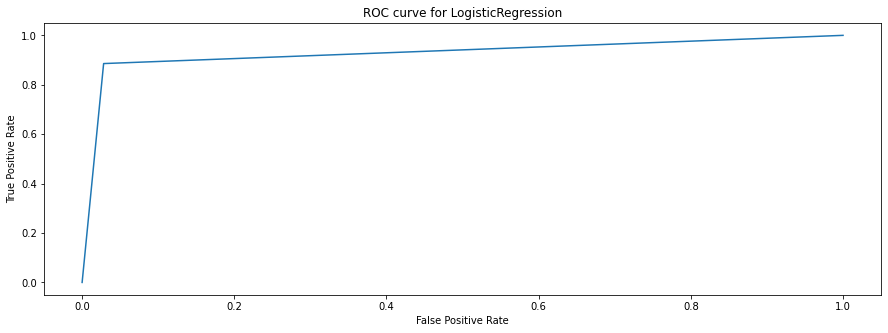

In [56]:
plot_Roc_Curve(gs_LR,X_test['CleanWordList'],y_test)

**Confusion Matrix**

In [22]:
import cf_matrix
# Reference: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

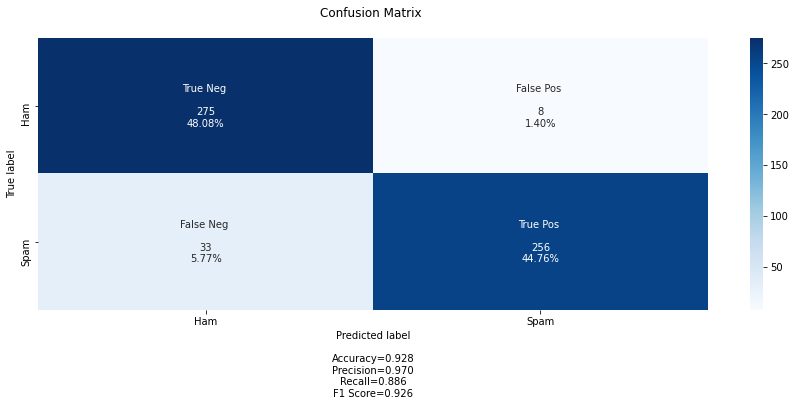

In [23]:
labels = ['True Neg \n','False Pos \n','False Neg \n','True Pos \n']

cm=confusion_matrix(y_test,gs_LR.predict(X_test['CleanWordList']))

cf_matrix.make_confusion_matrix(cm,figsize=(15,5),categories=['Ham','Spam'],
                                title='Confusion Matrix \n',group_names=labels)

**Classification Report**

In [57]:
print(classification_report(y_test,gs_LR.predict(X_test['CleanWordList'])))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       283
           1       0.97      0.89      0.93       289

    accuracy                           0.93       572
   macro avg       0.93      0.93      0.93       572
weighted avg       0.93      0.93      0.93       572



### **Adjust Threshold**

In [24]:
predict_proba=gs_LR.predict_proba(X_test['CleanWordList'])[:,1]

def adjustThreshold(predict_proba,threshold):
    predict_newThreshold=[]
    for prob in predict_proba:
        if prob<threshold:
            predict_newThreshold.append(0)
        else:
            predict_newThreshold.append(1)
    return predict_newThreshold

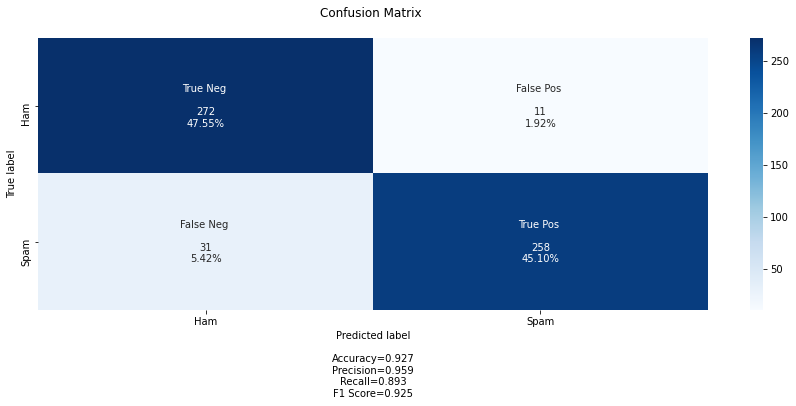

In [25]:
cm=confusion_matrix(y_test,adjustThreshold(predict_proba,0.4))

cf_matrix.make_confusion_matrix(cm,figsize=(15,5),categories=['Ham','Spam'],
                                title='Confusion Matrix \n',group_names=labels)

In [26]:
def calculateCMValues(cm):
    tp = cm[0][0] 
    fp = cm[0][1] 
    fn = cm[1][0] 
    tn = cm[1][1] 
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    F1=2*(precision*recall)/(precision+recall)
    return precision,recall,F1

In [28]:
threshold=np.arange(0,1,.01)

Precision=[]
F1=[]
for t in threshold:
    cm=confusion_matrix(y_test,adjustThreshold(predict_proba,t))
    Precision.append(calculateCMValues(cm)[0])
    F1.append(calculateCMValues(cm)[2])

In [29]:
def plotThresholdvsMetric(metric):
    precision_df=pd.DataFrame({'Threshold':threshold,'Precision':Precision,'F1':F1}).reset_index(drop=True)
    precision_df.fillna(0,inplace=True)
    
    xmark=precision_df[precision_df[metric]==max(precision_df[metric])]['Threshold'].iloc[0]
    ymark=precision_df[precision_df[metric]==max(precision_df[metric])][metric].iloc[0]
    
    text= "Threshold={:.3f},\n{}={:.4f}".format(xmark,metric,ymark)
    
    sns.lineplot(x='Threshold',y=metric,data=precision_df)
    plt.annotate(s=text,xy=(xmark,ymark))
    title='Threshold vs ' + metric
    plt.title(title);


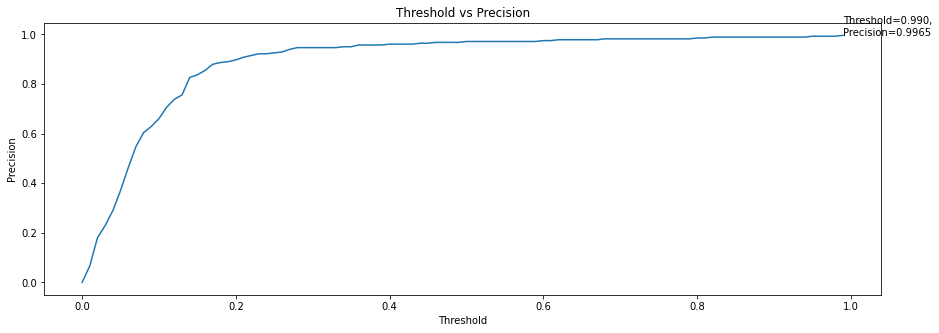

In [35]:
plotThresholdvsMetric('Precision')

Highest precision is found at threshold=0.99. 

**Check confusion matrix with threshold=0.99**

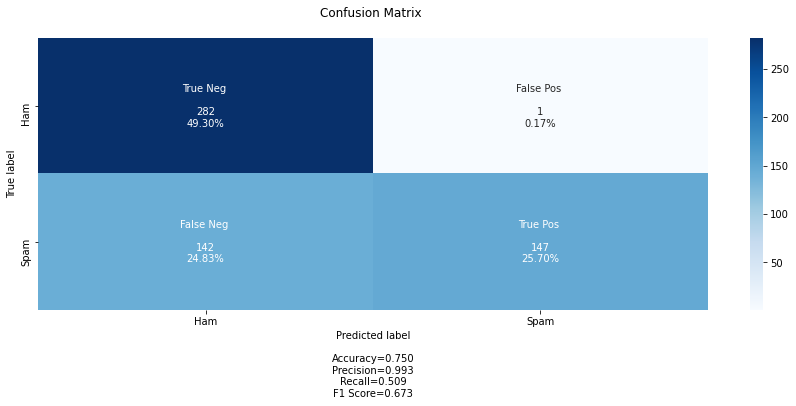

In [36]:
cm=confusion_matrix(y_test,adjustThreshold(predict_proba,0.99))
cf_matrix.make_confusion_matrix(cm,figsize=(15,5),categories=['Ham','Spam'],
                                title='Confusion Matrix \n',group_names=labels)

**Aiming for highest precision increased the false negative increase by 20%. We need to find a balance and we can use F1 for that.**

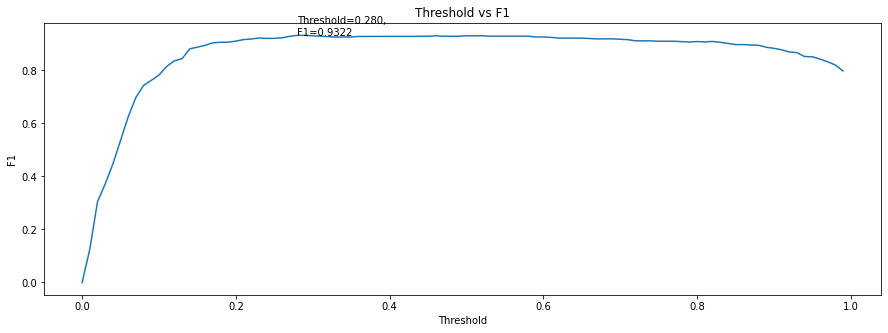

In [37]:
plotThresholdvsMetric('F1')

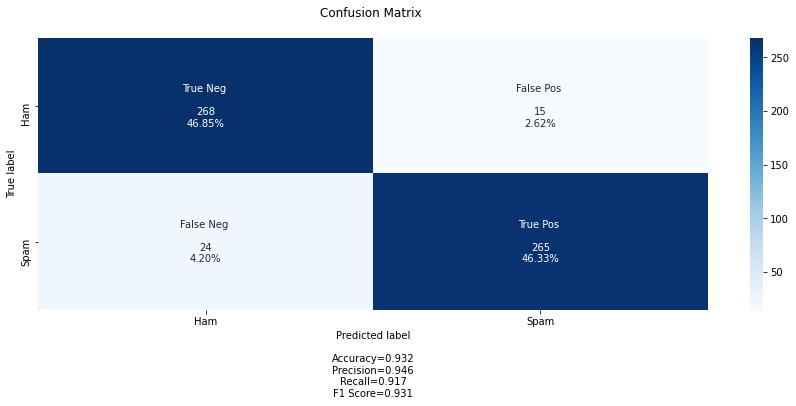

In [38]:
cm=confusion_matrix(y_test,adjustThreshold(predict_proba,0.28))
cf_matrix.make_confusion_matrix(cm,figsize=(15,5),categories=['Ham','Spam'],
                                title='Confusion Matrix \n',group_names=labels)

**Function to vectorize the comments. Convert the term document matrix into pandas dataframe and then add other generated features to this dataframe.**

In [ ]:
def create_document_term_matrix(X,vectorizer=gs_CompareVectorizer.best_estimator_['vectorizer']):
    """
    This function take in a dataframe with 'CleanWordList' column and vectorizes
    it using the vectorizer which was picked as best in the grid search for Vectorizers 
    
    It return 2 dataframes. First dataframe is a vector representation of text field and 
    the second dataframe has other engineered feature along with vectorized text
    """
    document_term_matrix = vectorizer.fit_transform(X['CleanWordList']) 
    colName=vectorizer.get_feature_names()
    
    X_dtm_df=pd.DataFrame(document_term_matrix.toarray(),columns=colName)
    X_dtm_all=pd.concat([X_dtm_df.reset_index(drop=True),
                      X.drop(columns=['COMMENT_ID','CleanWordList']).reset_index(drop=True)],
                     axis=1,ignore_index=False)


    return X_dtm_df,X_dtm_all


In [ ]:
def featureImportance(gs,X,y,engineeredFeatures=False,noOfFeatures=5):
    """
    Important features using Random Forest's feature_importances_ parameter.
    Set engineeredFeatured to True to include engineered features in calculation
    """
    
    X1,X2=create_document_term_matrix(X,gs_CV.estimator.named_steps['vectorizer'])
    
    if engineeredFeatures==True:
        X=X2
    else:
        X=X1
    
    #Random Forest is at 2 index in parameters list
    clf_rfc=gs.param_grid[2]['clf__estimator'][0].fit(X,y)

    impFeatures=clf_rfc.feature_importances_

    featureImportance=pd.DataFrame({'Feature Name':X.columns,
                                    'Importance':impFeatures})
    
    featureImportance.sort_values(by='Importance',ascending=False,inplace=True)
    
    return featureImportance.reset_index(drop=True).head(noOfFeatures)

In [ ]:
# List of most important features with all the features included in
featureImportance(gs_TFIDF,X_train,y_train)

In [ ]:
featureImportance(gs_TFIDF,X_train,y_train,engineeredFeatures=True,noOfFeatures=7)

In [ ]:
plot_Roc_Curve(gs_CV,X_test['CleanWordList'],y_test)

In [ ]:
cm=confusion_matrix(y_test,gs.predict(X_test_all))
cm

In [ ]:
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Greens):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion Matrix, without normalization')

#     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.grid(False)

# # import itertools
# # plot_confusion_matrix(gs,classes=['Spam','Ham'], normalize=False,
# #                           title='Confusion matrix')